In [21]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.trial import Trial
import seaborn as sns
from typing import List, Tuple

# Suppress Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [37]:

def objective(
    trial: Trial,
    X: np.ndarray,
    y: np.ndarray,
    folds: np.ndarray,
    unique_folds: np.ndarray
    ) -> float:
    """
    Optuna objective function for ElasticNet hyperparameter tuning.
    
    Args:
        trial: Optuna trial object
        X: Feature matrix
        y: Target variable array
        folds: Fold assignment array
        unique_folds: Array of unique fold identifiers
    
    Returns:
        Mean RMSE across all folds
    """
    # Suggest hyperparameters
    alpha = trial.suggest_float('alpha', 1e-5, 10.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    
    # Store fold metrics for this trial
    fold_scores = []
    
    # Cross-validation loop
    for fold in unique_folds:
        # Split data
        train_idx = folds != fold
        val_idx = folds == fold
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train ElasticNet
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=10000,
            random_state=42
        )
        
        model.fit(X_train, y_train)
        
        # Predict on validation set
        val_predictions = model.predict(X_val)
        
        # Calculate fold RMSE
        fold_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        fold_scores.append(fold_rmse)
    
    # Return mean RMSE across folds
    mean_rmse = np.mean(fold_scores)
    
    return mean_rmse


def train_and_evaluate_cv(
    X: np.ndarray,
    y: np.ndarray,
    folds: np.ndarray,
    unique_folds: np.ndarray,
    alpha: float,
    l1_ratio: float
    ) -> Tuple[np.ndarray, List[float], List[float], List[float]]:
    """
    Train ElasticNet model with cross-validation and return predictions and metrics.
    
    Args:
        X: Feature matrix
        y: Target variable array
        folds: Fold assignment array
        unique_folds: Array of unique fold identifiers
        alpha: ElasticNet alpha parameter
        l1_ratio: ElasticNet l1_ratio parameter
    
    Returns:
        Tuple containing:
            - oof_predictions: Out-of-fold predictions
            - fold_rmse_list: List of RMSE for each fold
            - fold_mae_list: List of MAE for each fold
            - fold_r2_list: List of R² for each fold
    """
    # Initialize arrays to store OOF predictions and fold metrics
    oof_predictions = np.zeros(len(y), dtype=np.float64)
    fold_rmse_list = []
    fold_mae_list = []
    fold_r2_list = []
    
    # Cross-validation loop with best parameters
    for fold in unique_folds:
        print(f"\nTraining fold {fold}...")
        
        # Split data
        train_idx = folds != fold
        val_idx = folds == fold
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        print(f"  Train samples: {len(y_train)}, Val samples: {len(y_val)}")
        
        # Train ElasticNet with best parameters
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=10000,
            random_state=42
        )
        
        model.fit(X_train, y_train)
        
        # Predict on validation set
        val_predictions = model.predict(X_val)
        oof_predictions[val_idx] = val_predictions
        
        # Calculate fold metrics
        fold_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        fold_mae = mean_absolute_error(y_val, val_predictions)
        fold_r2 = r2_score(y_val, val_predictions)
        
        fold_rmse_list.append(fold_rmse)
        fold_mae_list.append(fold_mae)
        fold_r2_list.append(fold_r2)
        
        print(f"  Fold {fold} - RMSE: {fold_rmse:.4f}, MAE: {fold_mae:.4f}, R²: {fold_r2:.4f}")
    
    return oof_predictions, fold_rmse_list, fold_mae_list, fold_r2_list


def train_final_model(
    X: np.ndarray,
    y: np.ndarray,
    alpha: float,
    l1_ratio: float
    ) -> ElasticNet:
    """
    Train final ElasticNet model on all data.
    
    Args:
        X: Feature matrix
        y: Target variable array
        alpha: ElasticNet alpha parameter
        l1_ratio: ElasticNet l1_ratio parameter
    
    Returns:
        Trained ElasticNet model
    """
    model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=10000,
        random_state=42
    )
    
    model.fit(X, y)
    
    return model


def print_model_coefficients(
    model: ElasticNet,
    wrap_every: int = 8
    ) -> None:
    """
    Print model coefficients as a formatted list, wrapped at specified intervals.
    
    Args:
        model: Trained ElasticNet model
        wrap_every: Number of coefficients to print per line
    """
    print(f"\nIntercept: {model.intercept_:.5f}\n")
    
    coefficients = model.coef_
    
    for i in range(0, len(coefficients), wrap_every):
        chunk_end = min(i + wrap_every, len(coefficients))
        coef_strings = [f"{coefficients[j]:.5f}" for j in range(i, chunk_end)]
        print(", ".join(coef_strings))



def create_regression_plot(
    y: np.ndarray,
    oof_predictions: np.ndarray,
    oof_r2: float,
    oof_rmse: float,
    oof_mae: float,
    output_path: str
    ) -> None:
    """
    Create and save a 1:1 regression plot.
    
    Args:
        y: Actual values
        oof_predictions: Predicted values
        oof_r2: Overall R² score
        oof_rmse: Overall RMSE
        oof_mae: Overall MAE
        output_path: Path to save the plot
    """
    # Ensure arrays are numeric
    y = np.asarray(y, dtype=np.float64)
    oof_predictions = np.asarray(oof_predictions, dtype=np.float64)
    
    plt.figure(figsize=(10, 10))
    
    # Scatter plot
    plt.scatter(y, oof_predictions, alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
    
    # Add 1:1 line
    min_val = float(min(y.min(), oof_predictions.min()))
    max_val = float(max(y.max(), oof_predictions.max()))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 Line')
    
    # Add best fit line
    z = np.polyfit(y, oof_predictions, 1)
    p = np.poly1d(z)
    plt.plot(y, p(y), "b-", linewidth=2, alpha=0.8, label=f'Best Fit: y={z[0]:.3f}x+{z[1]:.3f}')
    
    # Labels and title
    plt.xlabel('LiDAR Height (m)', fontsize=14, fontweight='bold')
    plt.ylabel('Predicted Height (m)', fontsize=14, fontweight='bold')
    plt.title(f'ElasticNet Out-of-Fold Predictions\nR² = {oof_r2:.4f}, RMSE = {oof_rmse:.4f} m', 
              fontsize=16, fontweight='bold')
    
    # Add grid
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add legend
    plt.legend(loc='upper left', fontsize=12)
    
    # Equal aspect ratio
    plt.axis('equal')
    plt.tight_layout()
    
    # Save plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved to: {output_path}")
    
    plt.show()


## File I/O

In [23]:
# Load the modeling dataset
gdf = gpd.read_file(r"C:\Users\johnb\Desktop\Google_Blog\data\aef_height_dataset.csv")

In [24]:
# Define the key dataset properties
fold_var = "fold_id"
dependent_var = "height_m"
independent_var = [
    'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 
    'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 
    'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 
    'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 
    'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 
    'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 
    'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 
    'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63'
]

In [25]:
# Get the response vector and the design matrix
X = gdf[independent_var].values
y = gdf[dependent_var].values.astype(np.float64)
folds = gdf[fold_var].values
unique_folds = np.unique(folds)


## Run the hyperparameter optimization 

Here, we use spatial cross-validation to tun the ElasticNet hyperparameters. 

In [26]:
study = optuna.create_study(direction='minimize', study_name='elasticnet_tuning')
study.optimize(
    lambda trial: objective(trial, X, y, folds, unique_folds),
    n_trials=100,
    show_progress_bar=True
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
print("\n" + "="*60)
print("Optimization completed!")
print(f"\nBest trial value (RMSE): {study.best_trial.value:.4f}")
print(f"Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value:.6f}")


Optimization completed!

Best trial value (RMSE): 3.2655
Best hyperparameters:
  alpha: 0.000078
  l1_ratio: 0.342700


In [28]:
# Train final model with best hyperparameters and evaluate with cross-validation
print("\nTraining final model with best hyperparameters...")
print("="*60)

best_alpha = study.best_params['alpha']
best_l1_ratio = study.best_params['l1_ratio']

# Train and evaluate
oof_predictions, fold_rmse_list, fold_mae_list, fold_r2_list = train_and_evaluate_cv(
    X, y, folds, unique_folds, best_alpha, best_l1_ratio
)



Training final model with best hyperparameters...

Training fold 1...
  Train samples: 3962, Val samples: 1038
  Fold 1 - RMSE: 3.4144, MAE: 2.6409, R²: 0.5042

Training fold 2...
  Train samples: 4012, Val samples: 988
  Fold 2 - RMSE: 3.2554, MAE: 2.4763, R²: 0.5840

Training fold 3...
  Train samples: 3983, Val samples: 1017
  Fold 3 - RMSE: 3.2064, MAE: 2.4285, R²: 0.5597

Training fold 4...
  Train samples: 3978, Val samples: 1022
  Fold 4 - RMSE: 3.3787, MAE: 2.6055, R²: 0.5874

Training fold 5...
  Train samples: 4065, Val samples: 935
  Fold 5 - RMSE: 3.0726, MAE: 2.3338, R²: 0.5133



Plot saved to: C:/Users/johnb/Desktop/Google_Blog/figures/elasticnet_oof_plot.png


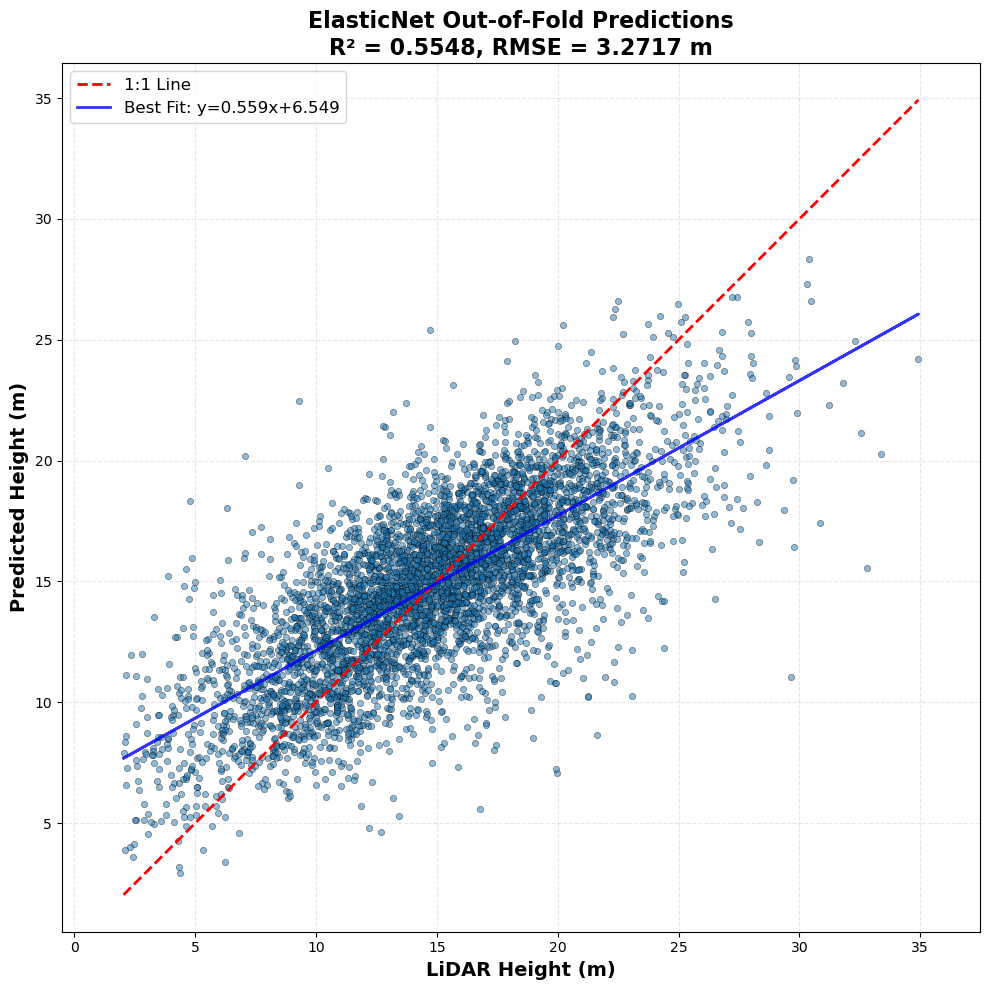

In [39]:
# Create regression plot
output_path = r"C:/Users/johnb/Desktop/Google_Blog/figures/elasticnet_oof_plot.png"
create_regression_plot(y, oof_predictions, oof_r2, oof_rmse, oof_mae, output_path)

In [30]:
# Calculate overall OOF metrics
oof_rmse = np.sqrt(mean_squared_error(y, oof_predictions))
oof_mae = mean_absolute_error(y, oof_predictions)
oof_r2 = r2_score(y, oof_predictions)

print("\nCross-Validation Scores (Mean ± Std Dev):")
print(f"  RMSE: {np.mean(fold_rmse_list):.4f} ± {np.std(fold_rmse_list):.4f}")
print(f"  MAE:  {np.mean(fold_mae_list):.4f} ± {np.std(fold_mae_list):.4f}")
print(f"  R²:   {np.mean(fold_r2_list):.4f} ± {np.std(fold_r2_list):.4f}")



Cross-Validation Scores (Mean ± Std Dev):
  RMSE: 3.2655 ± 0.1231
  MAE:  2.4970 ± 0.1134
  R²:   0.5497 ± 0.0349


In [31]:
# Train final model on all data
print("\nTraining final model on all data...")
final_model = train_final_model(X, y, best_alpha, best_l1_ratio)
print("Final model training complete!")



Training final model on all data...
Final model training complete!


In [34]:
# Print model coefficients
print_model_coefficients(final_model, wrap_every=8)


Intercept: 11.53513

1.45957, -0.90620, -2.88325, -7.73290, 5.60280, -6.12525, -6.58494, -0.56557
3.58247, -0.23105, -3.10215, 5.34825, 4.31927, 1.80639, -1.06402, 2.28553
-4.42215, 3.02548, 2.75686, -0.04212, 9.70114, 1.86458, 3.26989, 3.10177
17.52088, 5.64324, 2.77510, 1.24903, -6.37476, -7.97029, 3.29335, 7.40333
-6.37638, -8.09604, -1.09247, 5.48409, -6.23048, 1.38244, 5.78955, -11.91846
-17.61726, 0.25435, 7.09169, 5.12470, -3.13201, 3.02626, 7.85892, 10.35282
-9.31267, 13.52583, -9.03495, 0.37619, -1.82759, -0.00000, 3.65662, 13.14257
6.72767, 4.97101, -0.13353, 5.49163, 12.52566, 0.88531, 5.26727, -9.83451
